# POC: Get data and use case

 
- Source for use case 1: https://aclanthology.org/2021.newsum-1.9.pdf

In [1]:
import requests
from dotenv import load_dotenv
import pandas as pd
import os
pd.options.display.max_columns = 999


load_dotenv()


# note that CLIENT_ID refers to 'personal use script' and SECRET_TOKEN to 'token'
auth = requests.auth.HTTPBasicAuth(os.environ.get("NAME"), os.environ.get("SECRET"))

# here we pass our login method (password), username, and password
data = {'grant_type': 'password',
        'username': os.environ.get("USERNAME"),
        'password': os.environ.get("PASSCOMPTE")}

# setup our header info, which gives reddit a brief description of our app
headers = {'User-Agent': 'MyBot/0.0.1'}

# send our request for an OAuth token
res = requests.post('https://www.reddit.com/api/v1/access_token',
                    auth=auth, data=data, headers=headers)

# convert response to JSON and pull access_token value
TOKEN = res.json()['access_token']

# add authorization to our headers dictionary
headers = {**headers, **{'Authorization': f"bearer {TOKEN}"}}



## A - Request post from reddit API

### A.1 - Get the "hot" post from AITAH community 

In [126]:
columns = ["title", "selftext", "link_flair_text", "ups", "downs", "num_comments", "created", "edited", "author", "permalink"]

data = requests.get('https://oauth.reddit.com/r/AITAH/hot', headers=headers, params={'limit':'50'}).json()["data"]["children"]
data = pd.json_normalize(data)
data.columns = [c.replace("data.", "") for c in data.columns]  
posts = data[columns]

### A.2 - Get the comment from a post of AITAH community

Get data from 0 levels

In [131]:
i = 1
post_url = posts.permalink[i]
print(post_url, posts.num_comments[i])

/r/AITAH/comments/1dljyya/aita_for_what_i_told_my_mother_in_law_when_she/ 2501


In [137]:
comments = requests.get('https://oauth.reddit.com'+post_url, headers=headers, params={'limit':'10000'}).json()

comments = pd.json_normalize(comments[1]["data"]["children"])
comments.columns = [c.replace("data.", "") for c in comments.columns] 

columns_reduced = ['subreddit_id', 'author_is_blocked',
       'author_flair_type', 'replies.children', 'id', 'author',
       'created_utc', 'body', 'downs', 'ups']

comments = comments[columns_reduced]

In [138]:
comments

,subreddit_id,author_is_blocked,author_flair_type,replies.children,id,author,created_utc,body,downs,ups
0,t5_446kys,False,text,"[{'kind': 't1', 'data': {'subreddit_id': 't5_4...",l9pcty3,Present-Reflection84,1.719020e+09,NTA. Being in the delivery room is for support...,0.0,8025.0
1,t5_446kys,False,text,"[{'kind': 't1', 'data': {'subreddit_id': 't5_4...",l9pdf22,OverallOverlord,1.719020e+09,"""Fine with me, you won't be there then. I'll i...",0.0,3889.0
2,t5_446kys,False,text,"[{'kind': 't1', 'data': {'subreddit_id': 't5_4...",l9pb44f,ElDia13,1.719019e+09,NTA. This would be a deal breaker for me. Not ...,0.0,2402.0
3,t5_446kys,False,text,"[{'kind': 't1', 'data': {'subreddit_id': 't5_4...",l9ph9qg,trekgirl75,1.719022e+09,Is this a new pregnancy? With the same MIL? Bc...,0.0,445.0
4,t5_446kys,False,text,"[{'kind': 't1', 'data': {'subreddit_id': 't5_4...",l9pc4hf,Melificent40,1.719020e+09,NTA. The person whose nether regions will be ...,0.0,803.0
...,...,...,...,...,...,...,...,...,...,...
170,t5_446kys,False,text,NaN,l9rb314,thulock,1.719062e+09,"NTA. If you haven't already, I recommend taki...",0.0,3.0
171,t5_446kys,False,text,NaN,l9rb6np,JodyNoel,1.719062e+09,NTA your husband needs to grow up. You’re givi...,0.0,3.0
172,t5_446kys,False,text,NaN,l9rbciq,HopePirate,1.719062e+09,NTA he's trying to invite people to a party he...,0.0,3.0
173,t5_446kys,False,text,NaN,l9rbubz,emmers28,1.719062e+09,NTA- giving birth is a medical event and shit ...,0.0,3.0


---

## B - Possible uses cases 

## Use Case 1: Sentence Similarity

**Aim:** Discover the similarity between sentences to group them by opinion (may require fine-tuning).  
**Data:** Comments from each post  
**Model:** [Paraphrase-Multilingual-MiniLM-L12-v2](https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2)

In [139]:
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer
import torch
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns

torch.cuda.is_available()

False

/home/romain/miniconda3/envs/projet/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


<Axes: >

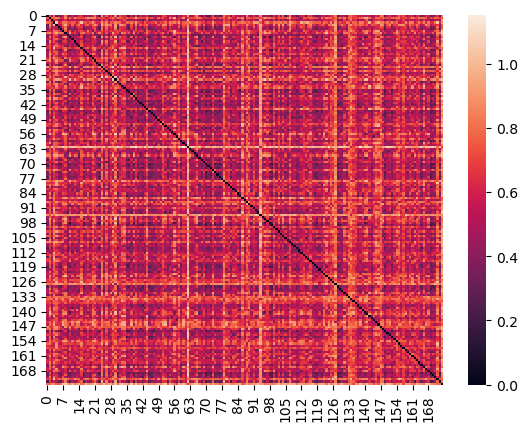

In [140]:
cos_dist = sc.spatial.distance.cosine
sentences = comments.body.to_list()

model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
embeddings = model.encode(sentences)

matrix = [[cos_dist(e1, e2) for e1 in embeddings] for e2 in embeddings]

sns.heatmap(matrix)

In [144]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca = pca.fit(embeddings)
features = pca.transform(embeddings)

db = DBSCAN(eps=0.3)
pred = db.fit_predict(features)
comments[pred == 1]


,subreddit_id,author_is_blocked,author_flair_type,replies.children,id,author,created_utc,body,downs,ups
53,t5_446kys,False,text,"[{'kind': 'more', 'data': {'count': 1, 'name':...",l9pvhx2,catinnameonly,1.719029e+09,NTA - You are under reacting. “If you miss our...,0.0,10.0
57,t5_446kys,False,text,NaN,l9pjh17,BigGingerYeti,1.719023e+09,"""it's alright, you can have the opportunity to...",0.0,4.0
132,t5_446kys,False,text,NaN,l9q9iun,Millie141,1.719037e+09,NTA- you’re the one going through a dangerous ...,0.0,3.0
144,t5_446kys,False,text,NaN,l9qki1q,Jotsunpls,1.719045e+09,I lost it at the «you can be in the delivery r...,0.0,3.0
154,t5_446kys,False,text,NaN,l9qxk6p,Ballard_77,1.719054e+09,NTA\nIt didn't end up mastering because my mot...,0.0,3.0


## Use Case 2: Emotion Detection of Posts

**Aim:** Detect the general emotion in each post  
**Data:** Posts from AITAH  
**Model:** [Emotion-English-DistilRoBERTa-Base](https://huggingface.co/j-hartmann/emotion-english-distilroberta-base)

In [41]:
from transformers import pipeline
from tqdm import tqdm
import numpy as np

classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True)

labels = []
for title in tqdm(posts.title):
    
    labels_post = classifier(title)
    list_label_post = []
    for detail_label in labels_post[0]:
        if detail_label["score"] > 0.20: ## TODO: Threshold not analysied
            list_label_post.append(detail_label["label"])
    labels.append(list_label_post)

labels = pd.Series(labels, name="label")

/home/romain/anaconda3/envs/projet/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/romain/anaconda3/envs/projet/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
100%|██████████| 51/51 [00:02<00:00, 24.41it/s]


In [43]:
classified_posts = pd.concat((posts, labels), axis=1)
classified_posts[["title", "selftext", "label"]]

,title,selftext,label
0,r/AITAH Lounge,A place for members of r/AITAH to chat with ea...,[neutral]
1,AITAH for breaking up with my girlfriend when ...,When I was 16 years old my girlfriend broke up...,[fear]
2,AITA for kicking my husband out of the house a...,"I (28F) have been married to my husband, Steve...",[disgust]
3,AITAH for approaching women at the bar while m...,My wife (35f) and I (36m) went to a bar last w...,[disgust]
4,AITAH for not giving my wife the full reason t...,My wife and I have been discussing baby names ...,"[anger, disgust]"
5,Family forgot I was a Father.,"\nSo, literally, both kids and my wife, all wh...","[neutral, sadness, surprise]"
6,AITAH for refusing to change items on my dinne...,I will try to keep this short. We are having a...,"[anger, neutral, surprise]"
7,AITA for putting in a claim to my late father’...,[Original post](https://www.reddit.com/r/AITAH...,"[anger, neutral, sadness]"
8,AITAH for not wanting a baby girl so my MIL wo...,I 28(F) am pregnant and about to deliver our f...,"[sadness, surprise]"
9,AITAH for not spending Father’s Day with my wi...,I (34M) have been married to my wife (32F) for...,"[anger, disgust, surprise]"


In [50]:
from pprint import pprint
pprint(classified_posts.iloc[36].title)

('AITAH for telling my boyfriend if he doesn’t want to have sex with me, then '
 'we need to break up? ')
